In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from torch_geometric.loader import DataLoader
from dataset_copy import *
from model import *
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score, roc_auc_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = 'cpu'

Dataset type:  <class 'dataset_copy.ChiralLigands'>
Dataset node features:  7
Dataset length:  <bound method ChiralLigands.len of ChiralLigands(686)>
Dataset sample:  Data(x=[92, 7], edge_index=[2, 196], edge_attr=[196, 2], y=[1], category=[1], ligand='C1=C(Cc2ccccc2)[C@H]2C=C(Cc3ccccc3)[C@@H]1C2', substrate='O=C1C=CCC1', boron='c1ccc(B2OB(c3ccccc3)OB(c3ccccc3)O2)cc1', ligand_num=1, ligand_id='L3.1', ligand_fam='fam1', idx=0)
Sample features:  tensor([[6., 3., 3., 0., 1., 0., 1.],
        [6., 3., 3., 0., 1., 0., 1.],
        [6., 4., 4., 0., 0., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 4., 4., 0., 1., 1., 1.],
        [6., 3., 3., 0., 1., 0., 1.],
        [6., 3., 3., 0., 1., 0., 1.],
        [6., 4., 4., 0., 0., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 3., 3.,

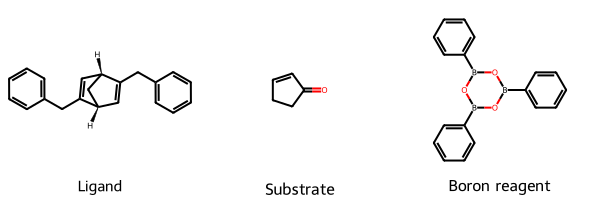

In [4]:
ligands = ChiralLigands(root = '/Users/ed/Documents/PhD_Documents/Annual Review/1st year/Code/ChiralLigands/Data', filename = 'data_aug.csv')

print("Dataset type: ", type(ligands))
print("Dataset node features: ", ligands.num_features)
print("Dataset length: ", ligands.len)
print("Dataset sample: ", ligands[0])
print('Sample features: ',  ligands[0].x)
print('Sample outcome: ',  ligands[0].y)
print('Sample cat: ',  ligands[0].category)

ms = [ligands[0].ligand, ligands[0].substrate, ligands[0].boron]
ms = [Chem.MolFromSmiles(mol) for mol in ms]
Chem.Draw.MolsToGridImage(ms,molsPerRow=3,subImgSize=(200,200),legends=['Ligand', 'Substrate', 'Boron reagent']) 

In [5]:
model = GCN_loop(ligands.num_features, embedding_size = 64, gnn_layers=2, improved=True)
#model = GAT_loop(ligands.num_features, embedding_size = 64, gnn_layers=3, nheads=1, concat=False)
#model = NN_model(ligands.num_features, ligands.num_edge_features, 50)
model.to(device)

GCN_loop(
  (initial_conv): GCNConv(7, 64)
  (conv_layers): ModuleList(
    (0): GCNConv(64, 64)
  )
  (readout1): Linear(in_features=128, out_features=64, bias=True)
  (readout2): Linear(in_features=64, out_features=1, bias=True)
)

In [6]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

In [7]:
categories = np.array([ligands[i].category.detach().numpy() for i in range(len(ligands))])
x = [ligands[i].x.detach().numpy() for i in range(len(ligands))]
groups = [ligands[i].ligand_num for i in range(len(ligands))]

In [8]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=23)
train_idx = []
test_idx = []

for i, (train, test) in enumerate(folds.split(x, categories)):
    train_idx.append(train)
    test_idx.append(test)

In [9]:
i = 5
train_loader = DataLoader(ligands[train_idx[i]], batch_size=40, shuffle=True)
test_loader = DataLoader(ligands[test_idx[i]], batch_size=40, shuffle=False)

In [10]:
def calculate_metrics(y_pred, y_true, epoch, type):
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_pred)
    
    if epoch % 5 == 0:
        print('\n \n' + type)
        print(f"\n Confusion matrix: \n {confusion_matrix(y_pred, y_true)}")
        print(f"F1 Score: {f1_score(y_true, y_pred):.2f}")
        print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
        print(f"Precision: {prec:.2f}")
        print(f"Recall: {rec:.2f}")
        print(f"ROC AUC: {roc:.2f}")

    return prec, rec, roc 

In [11]:
def train(epoch):

    all_preds = []
    all_y = []
    total_loss = 0
    step = 0

    # Enumerate over the data
    for batch in train_loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred = model(batch.x.float(), 
                  batch.edge_index,
                  #batch.edge_attr,
                  batch.batch) 
      
      # Calculating the loss and gradients
      loss = loss_fn(pred, torch.unsqueeze(batch.category.float(), dim = 1))
      loss.backward()  
      # Update using the gradients
      optimizer.step()   

      total_loss += loss.item()
      step += 1

      all_preds.append(np.rint(torch.sigmoid(pred).cpu().detach().numpy()))
      all_y.append(batch.category.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate (all_y).ravel() 
    metrics = calculate_metrics(all_preds, all_labels, epoch, 'train')

    return torch.tensor(total_loss/step), all_preds, all_labels, metrics

In [12]:
def test(epoch):

    all_preds = []
    all_y = []
    total_loss = 0
    step = 0

    # Enumerate over the data
    for batch in test_loader:
      # Use GPU
      batch.to(device)  
      # Passing the node features and the connection info
      pred = model(batch.x.float(), 
                  batch.edge_index,
                  #batch.edge_attr,
                  batch.batch) 
      
      # Calculating the loss and gradients
      loss = loss_fn(pred, torch.unsqueeze(batch.category.float(), dim = 1))
  
      total_loss += loss.item()
      step += 1

      all_preds.append(np.rint(torch.sigmoid(pred).cpu().detach().numpy()))
      all_y.append(batch.category.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate (all_y).ravel() 
    metrics = calculate_metrics(all_preds, all_labels, epoch, 'test')

    return torch.tensor(total_loss/step), all_preds, all_labels, metrics

In [13]:
epochs = 251

loss_train = []
loss_test = []

pred_train = []
pred_test = []

labels_train = []
labels_test = []

prec_train = []
prec_test = []

rec_train = []
rec_test = []

roc_train = []
roc_test = []

best_loss = 10_000
early_stopping_counter =0

for epoch in range (epochs):
            
    if early_stopping_counter <= 1000:
        # Training
        model.train()
        loss, pred, label, metrics = train(epoch=epoch)
        loss = loss.detach().cpu().numpy()

        if epoch % 5 == 0:
            loss_train.append(loss) 
            prec_train.append(metrics[0])
            rec_train.append(metrics[1])
            roc_train.append(metrics[2])

        if epoch % 100 == 0:
            print(f"Epoch {epoch} | Train Loss {loss}")
            pred_train.append(pred)
            labels_train.append(label)

                # Testing
            
        if epoch % 5 == 0:
            model.eval()
            loss, pred, label, metrics = test(epoch=epoch)
            loss = loss.detach().cpu().numpy()

            if float(loss) < best_loss:
                best_loss = loss
                early_stopping_counter = 0
                best_pred = pred
                best_y = label
                best_prec = metrics[0]
                best_rec = metrics[1]
                best_roc = metrics[2]
                best_epoch = epoch

            else:
                early_stopping_counter += 1

            
            loss_test.append(loss)
            prec_test.append(metrics[0])
            rec_test.append(metrics[1])
            roc_test.append(metrics[2])

            if epoch % 10 == 0:
                print(f"Epoch {epoch} | Test Loss {loss}")
                pred_test.append(pred)
                labels_test.append(label)
    
        last_epoch = epoch
                
    else:
        print("Early stopping due to no improvement.")
        print(f'Best loss was {best_loss}')
        last_epoch = epoch
        #break

print(f'Finishing training with best test loss: {best_loss}')
print(f'Best test precision: {best_prec}')
print(f'Best test recall: {best_rec}')
print(f'Best test auroc: {best_roc}')


 
train

 Confusion matrix: 
 [[162  85]
 [147 223]]
F1 Score: 0.66
Accuracy: 0.62
Precision: 0.60
Recall: 0.72
ROC AUC: 0.62
Epoch 0 | Train Loss 0.6665175557136536

 
test

 Confusion matrix: 
 [[34 35]
 [ 0  0]]
F1 Score: 0.00
Accuracy: 0.49
Precision: 0.00
Recall: 0.00
ROC AUC: 0.50
Epoch 0 | Test Loss 0.638991117477417

 
train

 Confusion matrix: 
 [[251  58]
 [ 58 250]]
F1 Score: 0.81
Accuracy: 0.81
Precision: 0.81
Recall: 0.81
ROC AUC: 0.81

 
test

 Confusion matrix: 
 [[30  4]
 [ 4 31]]
F1 Score: 0.89
Accuracy: 0.88
Precision: 0.89
Recall: 0.89
ROC AUC: 0.88

 
train

 Confusion matrix: 
 [[251  58]
 [ 58 250]]
F1 Score: 0.81
Accuracy: 0.81
Precision: 0.81
Recall: 0.81
ROC AUC: 0.81

 
test

 Confusion matrix: 
 [[30  4]
 [ 4 31]]
F1 Score: 0.89
Accuracy: 0.88
Precision: 0.89
Recall: 0.89
ROC AUC: 0.88
Epoch 10 | Test Loss 0.3692616820335388

 
train

 Confusion matrix: 
 [[251  58]
 [ 58 250]]
F1 Score: 0.81
Accuracy: 0.81
Precision: 0.81
Recall: 0.81
ROC AUC: 0.81

 
test


In [14]:
print(f'Best test precision: {best_prec}')
print(f'Best test recall: {best_rec}')
print(f'Best test auroc: {best_roc}')
print(f'Best epoch: {best_epoch}')

Best test precision: 0.9714285714285714
Best test recall: 0.9714285714285714
Best test auroc: 0.9710084033613445
Best epoch: 185


In [15]:
last_epoch = 251

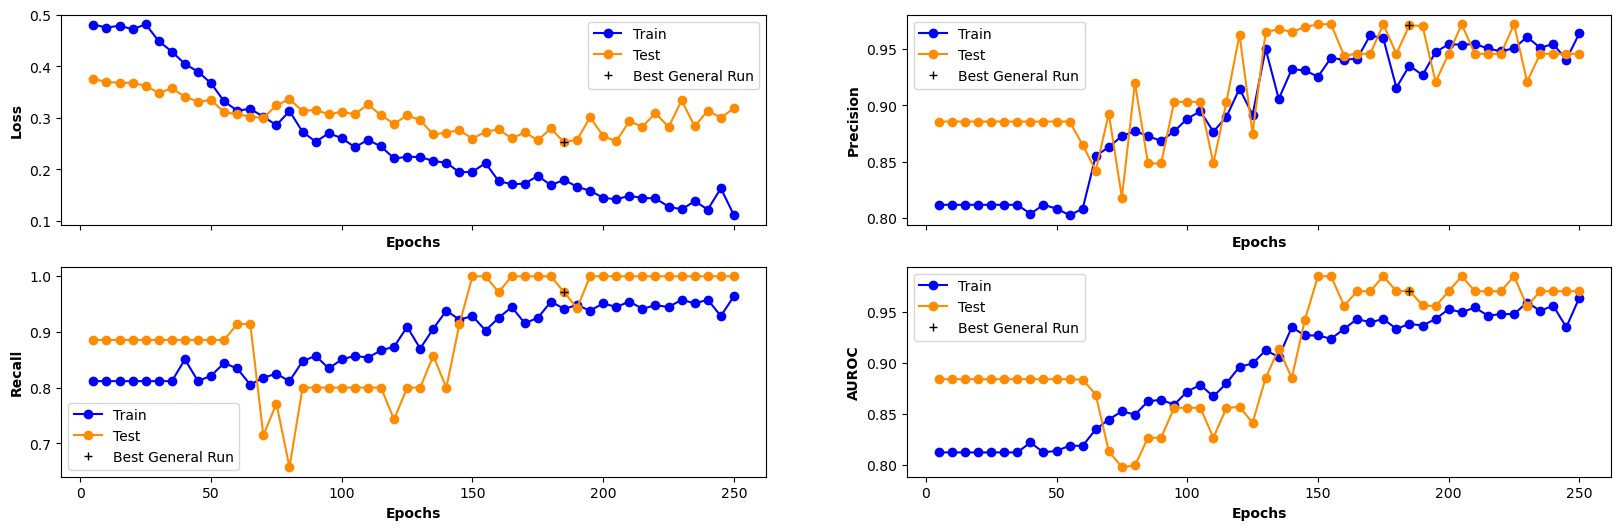

In [16]:
n = 1

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True,
                                    figsize=(20, 6))

axs[0,0].plot(range(0,last_epoch,5)[n:], loss_train[n:], 'o-', label = 'Train', color = 'blue')
axs[0,0].plot(range(0,last_epoch,5)[n:], loss_test[n:], 'o-', label = 'Test', color = 'darkorange')
axs[0,0].plot(best_epoch, best_loss, '+', label = 'Best General Run', color = 'black')
axs[0,0].set_xlabel('Epochs', fontweight ='bold', fontsize = 10)
axs[0,0].set_ylabel('Loss', fontweight ='bold', fontsize = 10)
axs[0,0].legend()

axs[0,1].plot(range(0,last_epoch,5)[n:], prec_train[n:], 'o-', label = 'Train', color = 'blue')
axs[0,1].plot(range(0,last_epoch,5)[n:], prec_test[n:], 'o-', label = 'Test', color = 'darkorange')
axs[0,1].plot(best_epoch, best_prec, '+', label = 'Best General Run', color = 'black')
axs[0,1].set_xlabel('Epochs', fontweight ='bold', fontsize = 10)
axs[0,1].set_ylabel('Precision', fontweight ='bold', fontsize = 10)
axs[0,1].legend()

axs[1,0].plot(range(0,last_epoch,5)[n:], rec_train[n:], 'o-', label = 'Train', color = 'blue')
axs[1,0].plot(range(0,last_epoch,5)[n:], rec_test[n:], 'o-', label = 'Test', color = 'darkorange')
axs[1,0].plot(best_epoch, best_rec, '+', label = 'Best General Run', color = 'black')
axs[1,0].set_xlabel('Epochs', fontweight ='bold', fontsize = 10)
axs[1,0].set_ylabel('Recall', fontweight ='bold', fontsize = 10)
axs[1,0].legend()

axs[1,1].plot(range(0,last_epoch,5)[n:], roc_train[n:], 'o-', label = 'Train', color = 'blue')
axs[1,1].plot(range(0,last_epoch,5)[n:], roc_test[n:], 'o-', label = 'Test', color = 'darkorange')
axs[1,1].plot(best_epoch, best_roc, '+', label = 'Best General Run', color = 'black')
axs[1,1].set_xlabel('Epochs', fontweight ='bold', fontsize = 10)
axs[1,1].set_ylabel('AUROC', fontweight ='bold', fontsize = 10)
axs[1,1].legend()

plt.show()

In [17]:
def train_folds(kfold, epoch, model, optimiser, loader):

    all_preds = []
    all_y = []
    all_logits = []
    all_ee = []
    index = []
    family = []
    ligand = []
    boron = []
    substrate = []

    total_loss = 0
    step = 0

    for batch in loader:

        # Use GPU
        batch.to(device)

        # Reset gradients
        optimiser.zero_grad()

        # Passing the node features and the connection info
        pred = model(batch.x.float(),  
                    batch.edge_index,
                    #batch.edge_attr,
                    batch.batch)
        
        # Calculating the loss and gradients
        loss = loss_fn(pred, torch.unsqueeze(batch.category.float(), dim = 1))
        loss.backward()

        # Update using the gradients
        optimiser.step() 

        total_loss += loss.item()
        step += 1

        all_preds.append(np.rint(torch.sigmoid(pred).cpu().detach().numpy()))
        all_logits.append(pred.cpu().detach().numpy())
        all_y.append(batch.category.cpu().detach().numpy())
        all_ee.append(batch.y.cpu().detach().numpy())
        index.append(batch.idx.cpu().detach().numpy())

        family.append(batch.ligand_fam)

        ligand.append(batch.ligand)
        boron.append(batch.boron)
        substrate.append(batch.substrate)
    
    all_preds = np.concatenate(all_preds).ravel()
    all_logits = np.concatenate(all_logits).ravel()
    all_labels = np.concatenate (all_y).ravel() 
    all_ee = np.concatenate(all_ee).ravel()
    index = np.concatenate(index).ravel()

    family = np.concatenate(family).ravel()

    ligand = np.expand_dims(np.concatenate(ligand).ravel(), 1)
    boron = np.expand_dims(np.concatenate(boron).ravel(),1)
    substrate = np.expand_dims(np.concatenate(substrate).ravel(),1)
    smiles = np.concatenate((ligand, boron, substrate), axis = 1)

    metrics = calculate_metrics(all_preds, all_labels, epoch, 'train')
    
    return torch.tensor(total_loss/step), all_preds, all_labels, metrics, all_logits, all_ee, smiles, index, family

In [18]:
def test_folds(kfold, epoch, model, loader):
    
    all_preds = []
    all_labels = []
    all_logits = []
    all_ee = []
    index = []
    family = []
    ligand = []
    boron = []
    substrate = []
    total_loss = 0
    step = 0

    for batch in loader:

        batch.to(device)
        pred = model(batch.x.float(),  
                        batch.edge_index,
                        #batch.edge_attr,
                        batch.batch)
        
        loss = loss_fn(pred, torch.unsqueeze(batch.category.float(), dim = 1))

        total_loss += loss.item()
        step += 1

        all_preds.append(np.rint(torch.sigmoid(pred).cpu().detach().numpy()))
        all_logits.append(pred.cpu().detach().numpy())
        all_labels.append(batch.category.cpu().detach().numpy())
        all_ee.append(batch.y.cpu().detach().numpy())
        index.append(batch.idx.cpu().detach().numpy())

        family.append(batch.ligand_fam)

        ligand.append(batch.ligand)
        boron.append(batch.boron)
        substrate.append(batch.substrate)

    all_preds = np.concatenate(all_preds).ravel()
    all_logits = np.concatenate(all_logits).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    all_ee = np.concatenate(all_ee).ravel()
    index = np.concatenate(index).ravel()

    family = np.concatenate(family).ravel()

    ligand = np.expand_dims(np.concatenate(ligand).ravel(), 1)
    boron = np.expand_dims(np.concatenate(boron).ravel(),1)
    substrate = np.expand_dims(np.concatenate(substrate).ravel(),1)
    smiles = np.concatenate((ligand, boron, substrate), axis = 1)
    
    metrics = calculate_metrics(all_preds, all_labels, epoch, 'test')

    return torch.tensor(total_loss/step), all_preds, all_labels, metrics, all_logits, all_ee, smiles, index, family

In [19]:
epochs = 251

#folds x times loss is saved
loss_train_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))
loss_test_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))

#folds x times loss is saved
prec_train_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))
prec_test_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))

#folds x times loss is saved
rec_train_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))
rec_test_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))

#folds x times loss is saved
roc_train_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))
roc_test_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))

#each element of the list holds a fold, first entry of the np array is the number of data points and second number of times stored
pred_train_folds = [np.zeros((len(train_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))] 
pred_test_folds = [np.zeros((len(test_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))]

#each element of the list holds a fold, first entry of the np array is the number of data points and second number of times stored
logits_train_folds = [np.zeros((len(train_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))] 
logits_test_folds = [np.zeros((len(test_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))]

#times lables are saved x number of predictions x folds
labels_train_folds = [np.zeros((len(train_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))] 
labels_test_folds = [np.zeros((len(test_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))]

#times lables are saved x number of predictions x folds
ee_train_folds = [np.zeros((len(train_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))] 
ee_test_folds = [np.zeros((len(test_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))]

#times lables are saved x number of predictions x folds
smiles_train_folds = [[[[None] *3] * len(train_idx[i])] * len(range(0, epochs, 5)) for i in range(len(train_idx))] 
smiles_test_folds = [[[[None] *3] * len(test_idx[i])] * len(range(0, epochs, 5)) for i in range(len(train_idx))] 

#times lables are saved x number of predictions x folds
index_train_folds = [np.zeros((len(train_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))] 
index_test_folds = [np.zeros((len(test_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))]

#times lables are saved x number of predictions x folds
family_train_folds = [[[None] * len(train_idx[i])] * len(range(0, epochs, 5)) for i in range(len(train_idx))] 
family_test_folds = [[[None] * len(test_idx[i])] * len(range(0, epochs, 5)) for i in range(len(train_idx))] 


best_loss_f = [None] * len(train_idx)
best_pred_f = [None] * len(train_idx)
best_y_f = [None] * len(train_idx)
best_prec_f = [None] * len(train_idx)
best_rec_f = [None] * len(train_idx)
best_roc_f = [None] * len(train_idx)
best_epoch_f = [None] * len(train_idx)

In [20]:
for fold in range(len(train_idx)):

    #model = NN_model(ligands.num_features, ligands.num_edge_features, 50)
    model = GCN_loop(ligands.num_features, embedding_size = 64, gnn_layers=2, improved=False)
    model.to(device)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    train_loader = DataLoader(ligands[train_idx[fold]], batch_size=40, shuffle=True)
    test_loader = DataLoader(ligands[test_idx[fold]], batch_size=40, shuffle=False)

    best_loss = 1_000


    for epoch in range (epochs):

        # Training
        model.train()
        loss, pred, label, metrics, logits, ee, smiles, index, family = train_folds(kfold = fold,
                                                  epoch=epoch,
                                                  model = model,
                                                  optimiser = optimizer,
                                                  loader = train_loader)
        
        loss = loss.detach().cpu().numpy()

        if epoch % 5 == 0:
            loss_train_folds[fold, int(epoch / 5)] = loss
            prec_train_folds[fold, int(epoch / 5)] = metrics[0]
            rec_train_folds[fold, int(epoch / 5)] = metrics[1]
            roc_train_folds[fold, int(epoch / 5)] = metrics[2]

        if epoch % 5 == 0:
            print(f"Epoch {epoch} | Fold {fold} | Train Loss {loss}")
            pred_train_folds[fold][:, int(epoch/5)] = pred
            labels_train_folds[fold][:, int(epoch/5)] = label
            logits_train_folds[fold][:, int(epoch/5)] = logits
            ee_train_folds[fold][:, int(epoch/5)] = ee
            smiles_train_folds[fold][int(epoch/5)] = smiles
            index_train_folds[fold][:, int(epoch/5)] = index
            family_train_folds[fold][int(epoch/5)] = family


        # Testing

        if epoch % 5 == 0:
            model.eval()
            loss, pred, label, metrics, logits, ee, smiles, index, family = test_folds(kfold = fold,
                                                    epoch=epoch,
                                                    model=model,
                                                    loader = test_loader)
            loss = loss.detach().cpu().numpy() 

            if float(loss) < best_loss:
                best_loss = loss
                best_loss_f[fold] = loss
                best_pred_f[fold] = pred
                best_y_f[fold] = label
                best_prec_f[fold] = metrics[0]
                best_rec_f[fold] = metrics[1]
                best_roc_f[fold] = metrics[2]
                best_epoch_f[fold] = epoch

            if epoch % 5 == 0:
                loss_test_folds[fold, int(epoch / 5)] = loss
                prec_test_folds[fold, int(epoch / 5)] = metrics[0]
                rec_test_folds[fold, int(epoch / 5)] = metrics[1]
                roc_test_folds[fold, int(epoch / 5)] = metrics[2]

            if epoch % 5 == 0:
                print(f"Epoch {epoch} | Fold {fold} | Test Loss {loss}")
                pred_test_folds[fold][:, int(epoch/5)] = pred
                labels_test_folds[fold][:, int(epoch/5)] = label
                logits_test_folds[fold][:, int(epoch/5)] = logits
                ee_test_folds[fold][:, int(epoch/5)] = ee
                smiles_test_folds[fold][int(epoch/5)] = smiles
                index_test_folds[fold][:, int(epoch/5)] = index
                family_test_folds[fold][int(epoch/5)] = family

    
    print(f'Done for fold {fold}')
    print(f'Best loss: {best_loss_f[fold]}')
    print(f'Best precision: {best_prec_f[fold]}')
    print(f'Best recall: {best_rec_f[fold]}')
    print(f'Best AUROC: {best_roc_f[fold]}')
    print(f'Best epoch: {best_epoch_f[fold]}')


 
train

 Confusion matrix: 
 [[218  95]
 [ 90 214]]
F1 Score: 0.70
Accuracy: 0.70
Precision: 0.70
Recall: 0.69
ROC AUC: 0.70
Epoch 0 | Fold 0 | Train Loss 0.6699170470237732

 
test

 Confusion matrix: 
 [[26  6]
 [ 9 28]]
F1 Score: 0.79
Accuracy: 0.78
Precision: 0.76
Recall: 0.82
ROC AUC: 0.78
Epoch 0 | Fold 0 | Test Loss 0.652643084526062

 
train

 Confusion matrix: 
 [[255  56]
 [ 53 253]]
F1 Score: 0.82
Accuracy: 0.82
Precision: 0.83
Recall: 0.82
ROC AUC: 0.82
Epoch 5 | Fold 0 | Train Loss 0.4606455862522125

 
test

 Confusion matrix: 
 [[26  6]
 [ 9 28]]
F1 Score: 0.79
Accuracy: 0.78
Precision: 0.76
Recall: 0.82
ROC AUC: 0.78
Epoch 5 | Fold 0 | Test Loss 0.5322966575622559

 
train

 Confusion matrix: 
 [[255  56]
 [ 53 253]]
F1 Score: 0.82
Accuracy: 0.82
Precision: 0.83
Recall: 0.82
ROC AUC: 0.82
Epoch 10 | Fold 0 | Train Loss 0.45697274804115295

 
test

 Confusion matrix: 
 [[26  6]
 [ 9 28]]
F1 Score: 0.79
Accuracy: 0.78
Precision: 0.76
Recall: 0.82
ROC AUC: 0.78
Epoch 10 

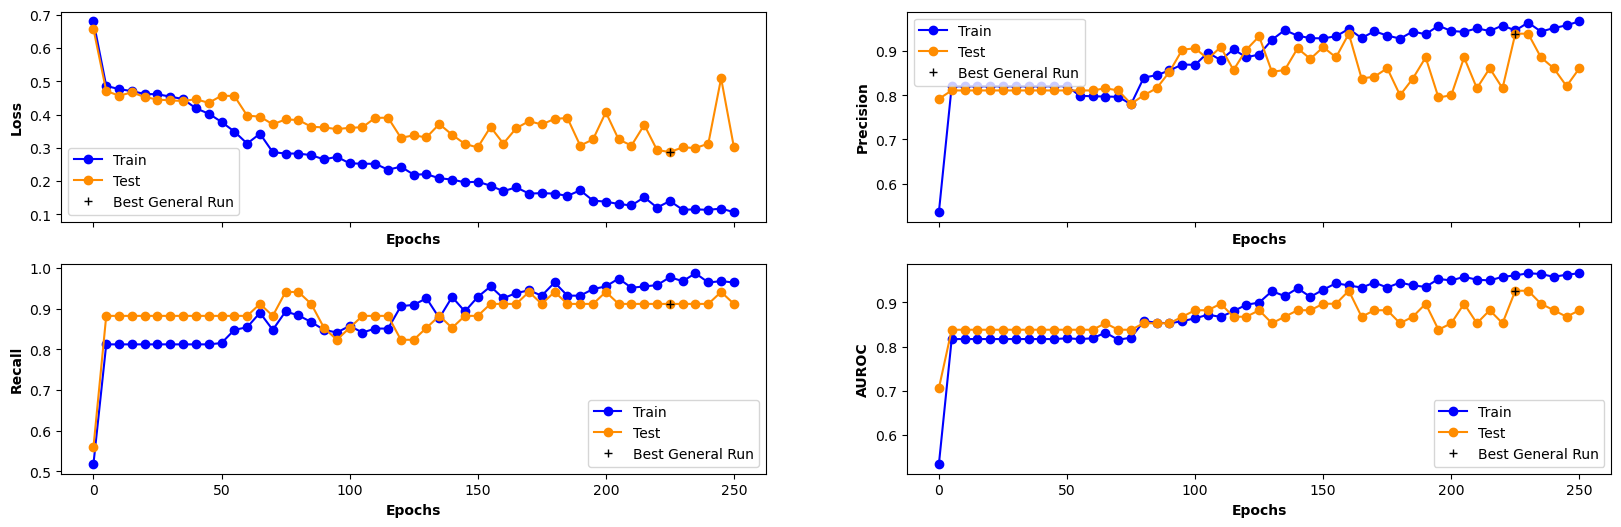

In [21]:
n = 0
f = 6
last_epoch = 251

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True,
                                    figsize=(20, 6))

axs[0,0].plot(range(0,last_epoch,5)[n:], loss_train_folds[f,:][n:], 'o-', label = 'Train', color = 'blue')
axs[0,0].plot(range(0,last_epoch,5)[n:], loss_test_folds[f,:][n:], 'o-', label = 'Test', color = 'darkorange')
axs[0,0].plot(best_epoch_f[f], best_loss_f[f], '+', label = 'Best General Run', color = 'black')
axs[0,0].set_xlabel('Epochs', fontweight ='bold', fontsize = 10)
axs[0,0].set_ylabel('Loss', fontweight ='bold', fontsize = 10)
axs[0,0].legend()

axs[0,1].plot(range(0,last_epoch,5)[n:], prec_train_folds[f,:][n:], 'o-', label = 'Train', color = 'blue')
axs[0,1].plot(range(0,last_epoch,5)[n:], prec_test_folds[f,:][n:], 'o-', label = 'Test', color = 'darkorange')
axs[0,1].plot(best_epoch_f[f], best_prec_f[f], '+', label = 'Best General Run', color = 'black')
axs[0,1].set_xlabel('Epochs', fontweight ='bold', fontsize = 10)
axs[0,1].set_ylabel('Precision', fontweight ='bold', fontsize = 10)
axs[0,1].legend()

axs[1,0].plot(range(0,last_epoch,5)[n:], rec_train_folds[f,:][n:], 'o-', label = 'Train', color = 'blue')
axs[1,0].plot(range(0,last_epoch,5)[n:], rec_test_folds[f,:][n:], 'o-', label = 'Test', color = 'darkorange')
axs[1,0].plot(best_epoch_f[f], best_rec_f[f], '+', label = 'Best General Run', color = 'black')
axs[1,0].set_xlabel('Epochs', fontweight ='bold', fontsize = 10)
axs[1,0].set_ylabel('Recall', fontweight ='bold', fontsize = 10)
axs[1,0].legend()

axs[1,1].plot(range(0,last_epoch,5)[n:], roc_train_folds[f,:][n:], 'o-', label = 'Train', color = 'blue')
axs[1,1].plot(range(0,last_epoch,5)[n:], roc_test_folds[f,:][n:], 'o-', label = 'Test', color = 'darkorange')
axs[1,1].plot(best_epoch_f[f], best_roc_f[f], '+', label = 'Best General Run', color = 'black')
axs[1,1].set_xlabel('Epochs', fontweight ='bold', fontsize = 10)
axs[1,1].set_ylabel('AUROC', fontweight ='bold', fontsize = 10)
axs[1,1].legend()

plt.show()

In [22]:
mean_prec_test = []
std_prec_test = []

mean_rec_test = []
std_rec_test = []

mean_roc_test = []
std_roc_test = []

for i in range(len(range(0,epochs,5))):

    mean_prec_test.append(np.mean(prec_test_folds[:,i]))
    std_prec_test.append(np.std(prec_test_folds[:,i]))

    mean_rec_test.append(np.mean(rec_test_folds[:,i]))
    std_rec_test.append(np.std(rec_test_folds[:,i]))

    mean_roc_test.append(np.mean(roc_test_folds[:,i]))
    std_roc_test.append(np.mean(roc_test_folds[:,i]))

In [23]:
print(f'e value for best precision: {mean_prec_test.index(max(mean_prec_test))}')
print(f'e value for best recall: {mean_rec_test.index(max(mean_rec_test))}')
print(f'e value for best AUROC: {mean_roc_test.index(max(mean_roc_test))}')

e value for best precision: 45
e value for best recall: 47
e value for best AUROC: 47


In [24]:
all = [sum(x) for x in zip(mean_prec_test, mean_rec_test, mean_roc_test)]
print(f'e value for best General: {all.index(max(all))}')

e value for best General: 47


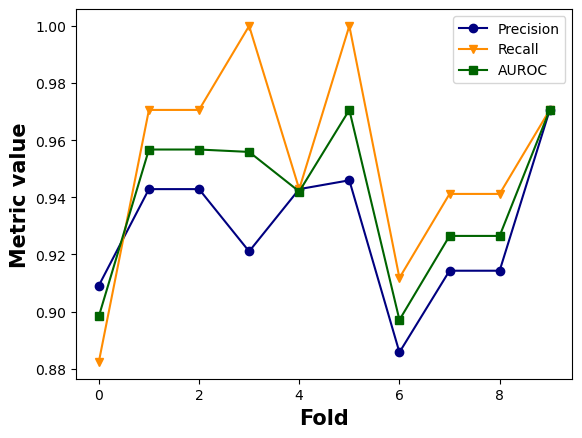

In [25]:
e = 47
plt.plot(figsize =(24, 16))
plt.plot(range(len(train_idx)), prec_test_folds[:,e], 'o-', label = 'Precision', color = 'navy')
plt.plot(range(len(train_idx)), rec_test_folds[:,e], 'v-', label = 'Recall', color = 'darkorange')
plt.plot(range(len(train_idx)), roc_test_folds[:,e], 's-', label = 'AUROC', color = 'darkgreen')


plt.xlabel('Fold', fontweight ='bold', fontsize = 15)
plt.ylabel('Metric value', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

In [26]:
e = 47
Metrics = ['Precision', 'Recall', 'AUROC']
x_pos = np.arange(len(Metrics))
CTEs = [round(np.mean(prec_test_folds[:,e]),3),round(np.mean(rec_test_folds[:,e]),3), round(np.mean(roc_test_folds[:,e]),3)]
error = [np.std(prec_test_folds[:,e]), np.std(rec_test_folds[:,e]), np.std(roc_test_folds[:,e])]

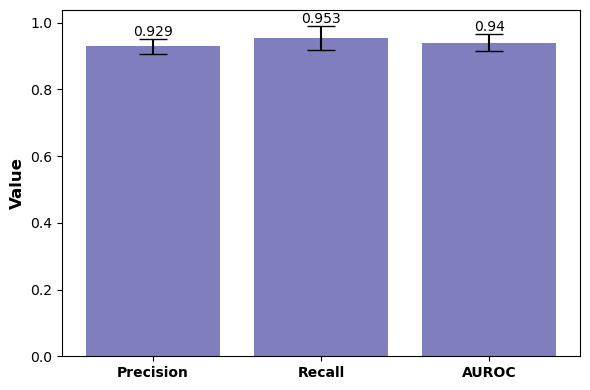

In [27]:
fig, ax = plt.subplots(figsize =(6, 4))
bars = ax.bar(x_pos, CTEs, yerr=error, align='center', color = 'navy', alpha=.5, ecolor='black', capsize=10)
ax.set_ylabel('Value', fontweight ='bold', fontsize = 12)
ax.bar_label(bars)
ax.set_xticks(x_pos)
ax.set_xticklabels(Metrics, fontweight ='bold' ,fontsize = 10)
ax.yaxis.grid(False)

plt.tight_layout()
plt.show()

In [28]:
e = 47
df = pd.DataFrame()

for f in range(len(train_idx)):
    fs = [f for _ in range(len(test_idx[f]))]
    data_set = ['test' for _ in range(len(test_idx[f]))]

    data = {
        'logits': logits_test_folds[f][:,e],
        'ee': ee_test_folds[f][:,e],
        'Prediction': pred_test_folds[f][:,e],
        'Category': labels_test_folds [f][:,e],
        'Ligand': smiles_test_folds[f][e][:,0],
        'Boron_reagent': smiles_test_folds[f][e][:,1],
        'Substrate': smiles_test_folds[f][e][:,2], 
        'family': family_test_folds[f][e],
        'index': index_test_folds[f][:,e],
        'fold': f,
        'set': data_set
    }

    df_f = pd.DataFrame(data)
    df = pd.concat([df, df_f], axis = 0)

    data_set = ['train' for _ in range(len(train_idx[f]))]

    data = {
    'logits': logits_train_folds[f][:,e],
    'ee': ee_train_folds[f][:,e],
    'Prediction': pred_train_folds[f][:,e],
    'Category': labels_train_folds [f][:,e],
    'Ligand': smiles_train_folds[f][e][:,0],
    'Boron_reagent': smiles_train_folds[f][e][:,1],
    'Substrate': smiles_train_folds[f][e][:,2], 
    'family': family_train_folds[f][e],
    'index': index_train_folds[f][:,e],
    'fold': f,
    'set': data_set
    }

    df_f = pd.DataFrame(data)
    df = pd.concat([df, df_f], axis = 0)



df = df.set_index('index')
df

,logits,ee,Prediction,Category,Ligand,Boron_reagent,Substrate,family,fold,set
index,,,,,,,,,,
9.0,-7.295114,2.25,0.0,0.0,C1=C(Cc2ccccc2)[C@H]2C=C(Cc3ccccc3)[C@@H]1C2,OB(O)c1ccccc1,CC(=O)/C=C/C(C)C,fam1,0,test
15.0,-4.200037,15.00,0.0,0.0,C1=C(Cc2ccccc2)[C@H]2C=C(Cc3ccccc3)[C@@H]1C2,OB(O)c1ccccc1,CN1C(=O)C=CC1=O,fam1,0,test
27.0,-8.355241,1.00,0.0,0.0,CC1(C)[C@@H]2C=C(c3ccccc3)[C@@]1(C)C=C2c1ccccc1,OB(O)c1ccc(-c2ccccc2)cc1,CC(C)(C)OC(=O)/C=C/C(=O)OC(C)(C)C,fam2,0,test
31.0,-6.888633,1.75,0.0,0.0,CC1(C)[C@@H]2C=C(c3ccccc3)[C@@]1(C)C=C2c1ccccc1,OB(O)c1cccc2ccccc12,CC(C)(C)OC(=O)/C=C/C(=O)OC(C)(C)C,fam2,0,test
37.0,-0.624045,11.00,0.0,0.0,CC(C)(C)c1ccc(C2=C[C@]3(C)C(c4ccc(C(C)(C)C)cc4...,OB(O)c1ccccc1,CC(=O)/C=C/C(C)C,fam2,0,test
...,...,...,...,...,...,...,...,...,...,...
230.0,-6.740014,1.50,0.0,0.0,CC(C)(OCOCc1ccccc1)C1=C[C@@H]2C=C[C@H]1C2,OB(O)c1ccccc1,O=C1C=CCC1,fam1,9,train
594.0,-1.291749,4.50,0.0,0.0,C=CCC1=C[C@]2(C)C[C@@](C)(OC)[C@H]1C=C2CC(C)C,OB(O)c1ccccc1,O=C1C=CCO1,fam6,9,train
94.0,-6.340045,11.00,0.0,0.0,COc1ccc(C2=C[C@H]3CC[C@@H]2C=C3c2ccc(OC)cc2)cc1,OB(O)c1ccccc1,CC(=O)/C=C/C(C)C,fam3,9,train


In [29]:
df.to_csv(f'/Users/ed/Documents/PhD_Documents/Annual Review/1st year/Code/ChiralLigands/Analyse_results/Interactive_plots_class/ligands_allfolds_e{e}_GCN_epochs_{e*5}.csv')